# Sampling Calculation

Here we will sample the IMF to populate a given star formation history (SFH) and interpolate all of the created stars to the Roman Bands

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
## a function for evaluating the IMF
def xi_IMF(m, mpows, mcuts):
    norm_sum = 0.0
    norm_list = [1.0]
    res_pdf = np.zeros(m.shape)
    for i in range(len(mpows)):
        mi = mcuts[i+1]
        mim1 = mcuts[i]
        ai = mpows[i]
        norm_sum += norm_list[-1]*mim1*((mi/mim1)**(1+ai) - 1.)/(1+ai)
        res_pdf += (m>mim1)*(m<mi)*norm_list[i]*(m/mim1)**ai
        norm_list.append(norm_list[-1]*(mi/mim1)**ai)
    norm = 1./norm_sum
    res_pdf *= norm
    return res_pdf



## a function for calcaulating the cumulative 
## distribution function of the imf, for sampling
def cdf_imf(m, mpows, mcuts):
    res_cdf = np.zeros(m.shape)
    norm_sum = 0.0
    norm_list = [1.0]
    for i in range(len(mpows)):
        mi = mcuts[i+1]
        mim1 = mcuts[i]
        ai = mpows[i]
        norm_sum += norm_list[-1]*mim1*((mi/mim1)**(1+ai) - 1.)/(1+ai)
        # if greater than upper limit of integration range, add full integral
        res_cdf += (m>mi)*norm_list[-1]*mim1*((mi/mim1)**(1+ai) - 1.)/(1+ai)
        # if between lower and upper limit, add partial integral
        res_cdf += (m>mim1)*(m<mi)*norm_list[-1]*mim1*((m/mim1)**(1+ai) - 1.)/(1+ai)
        norm_list.append(norm_list[-1]*(mi/mim1)**ai)
    norm = 1./norm_sum
    res_cdf *= norm
    return res_cdf

# a function to calculate the average mass for a
# broken powerlaw (bp) IMF
def avg_m_bp(mpows, mcuts):
    # mpows : list of powers len(mpows) = N
    # mcuts : list of mass ranges len(mcuts) = N + 1
    if (len(mcuts) != len(mpows) + 1):
        print("Mismatch in length of powers and mass cuts provided to the IMF")
        assert(False)
    mavg_sum = 0.0
    norm_sum = 0.0
    norm_list = [1.0]
    for i in range(len(mpows)):
        mi = mcuts[i+1]
        mim1 = mcuts[i]
        ai = mpows[i]
        norm_sum += norm_list[-1]*mim1*((mi/mim1)**(1+ai) - 1.)/(1+ai)
        # if greater than upper limit of integration range, add full integral
        mavg_sum += norm_list[-1]*(mim1**2)*((mi/mim1)**(2+ai) - 1.)/(2+ai)
        norm_list.append(norm_list[-1]*(mi/mim1)**ai)
    norm = 1./norm_sum
    mavg_sum *= norm
    return mavg_sum    

# function for sampling a distibution provided its one dimensional inverse CDF
def cdf_samp(n, cdf_inv):
    # function that samples a distribution
    # n : number of samples to take
    # cdf_inv : array giving the inverse of the cumulative distribution function (CDF)
    #           of some probability distribution, assumes that this is sampled linearly
    #           between one an zero
    if(len(cdf_inv.shape)!=1):
        print("Shape of CDF array is wrong, should be one dimensional")
    nsamp = np.random.random(n)
    return np.interp(nsamp,np.linspace(0,1, cdf_inv.shape[0]), cdf_inv)

# function to get about the right mass of stars
def gen_mass_samp(Mtot, cdf_inv, mavg):
    Nguess = int(1.1*Mtot/mavg)
    msamp = cdf_samp(Nguess, cdf_inv)
    return msamp[np.where(np.cumsum(msamp)< Mtot)]

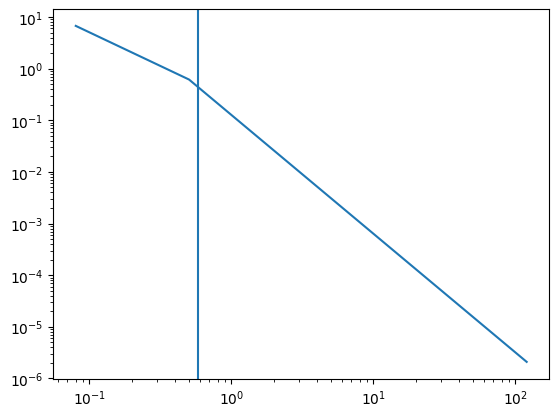

In [3]:
powers = [-1.3,-2.3]
massLimits = [0.08,0.5,120]

mlin = np.logspace(np.log10(massLimits[0]),np.log10(massLimits[-1]),10000)

plt.plot(mlin[1:], xi_IMF(mlin,powers,massLimits)[1:])
plt.axvline(x=avg_m_bp(powers, massLimits))
plt.yscale("log")
plt.xscale("log")

In [4]:
# First specify the properties of the populations you'd like to calculate f_detect for
# by giving lists of metallicities and ages. These should be linearly spaced (in the log 
# space in which they are defined)
metlist = np.array([0.5,0.25,0.0,-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0,-2.25,-2.5,-2.75,-3.,-3.25])
agelist = np.array([8.95,9.,9.05,9.1,9.15,9.2,9.25,9.3,9.35,9.4,9.45,9.5,9.55,9.6,9.65,9.7,9.75,9.8,9.85,9.9,9.95,10.,10.05,10.1])
nmet = len(metlist) # number of metallicities
nage = len(agelist) # number of ages
dage = agelist[1] - agelist[0] # logarithmic difference in age bins, for selection below

## specify directory where isochrones are stored, this is set up for the 
## MIST Roman Isocrones, changing that would involve changing the below
iso_dir = "../../mist_isos/"
## name od output file
output_name = "../data/lum_mist" # it will have a .npy at the end

## define the IMF normalization
## specify the power-law indices for the IMF that you would like to use
## here we define a Kroupa IMF
mpows = [-1.3,-2.3]
mcuts = [0.08,0.5,120]
assert(len(mpows)+1==len(mcuts))
## specify the number of mass samples you would like for integrals of the IMF
nmass_samp = 100000
# mass range in solar masses
(mMin,mMax) = (mcuts[0],mcuts[-1])
# masses spaced linearly throughout imf space
mlin = np.linspace(mMin,mMax,nmass_samp)
# evaluate IMF
xi = xi_IMF(mlin, mpows, mcuts)

# get the properties of the IMF
# average mass of IMF
MAVG = avg_m_bp(mpows, mcuts)
mlin = np.linspace(mcuts[0], mcuts[-1], 100000)
CDF = cdf_imf(mlin, mpows, mcuts)[1:-1]
CDF = np.concatenate((np.array([0]),CDF,np.array([1.0])))
plin = np.linspace(0, 1, 100000)
CDF_INV = np.interp(plin, CDF, mlin)


# specify the number of filters. The default is 7 (R,Z,Y,J,W,H,F). Changing this 
# number will require some hard code changes below
nfilts = 7
# conversion from Vega mags to AB mags for each band
AB_Vega = np.array([0.147,0.485,0.647,0.950,1.012,1.281,1.546]) #This is m_AB - m_Vega

In [5]:
nage, nmet

(24, 16)

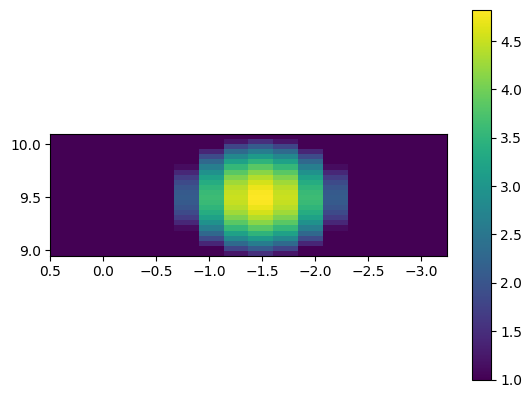

In [32]:
# specify star formation history 
# sfh[i][j] is mass formed at agelist[i] with metallicity metlist[j]
sfh = np.zeros((nage,nmet))
age_grid = np.array([agelist for i in range(nmet)]).T
met_grid = np.array([metlist for i in range(nage)])

# specifying the SFH in terms of gaussian distributions 
(met0,met_spread) = (-1.5,0.3)
(age0,age_spread) = (9.5,0.2)
sfh = np.exp(-1*((met_grid-met0)/met_spread)**2)*np.exp(-1*((age_grid-age0)/age_spread)**2)
sfh /= np.sum(sfh)
sfh *= 1e6

plt.imshow(np.log10(sfh)[::-1,:], extent=(metlist[0],metlist[-1],agelist[0],agelist[-1]), vmin =1)
#plt.imshow(age_grid[::-1,:], extent=(10,20,agelist[0],agelist[-1]))
#plt.imshow(met_grid[::-1,:], extent=(metlist[0],metlist[-1],agelist[0],agelist[-1]))
plt.colorbar()

In [33]:
out_data= np.array([np.zeros(nfilts)])

# shape of the total output array
totdat = np.zeros((nmet,nage,nfilts))
for (l,met) in enumerate(metlist):
    print(met)
    if met>-0.1:
        (age,imass,T,L) = np.loadtxt("%smist_fehp%1.2f.iso.cmd"%(iso_dir,abs(met)),usecols=[1,2,4,6]).T
        (R,Z,Y,J,W,H,F) = np.loadtxt("%smist_fehp%1.2f.iso.cmd"%(iso_dir,abs(met)),usecols=[9,10,11,12,13,14,15]).T
    else:
        (age,imass,T,L) = np.loadtxt("%smist_fehm%1.2f.iso.cmd"%(iso_dir,abs(met)),usecols=[1,2,4,6]).T
        (R,Z,Y,J,W,H,F) = np.loadtxt("%smist_fehm%1.2f.iso.cmd"%(iso_dir,abs(met)),usecols=[9,10,11,12,13,14,15]).T

    (Rage,Zage,Yage,Jage,Wage,Hage,Fage) = (np.zeros(nage),np.zeros(nage),np.zeros(nage),np.zeros(nage),np.zeros(nage),np.zeros(nage),np.zeros(nage))
    for (k,a) in enumerate(agelist):
        sids = np.intersect1d(np.where(age>a-dage/2),np.where(age<a+dage/2))

        mtot = sfh[k][l]
        msi = gen_mass_samp(mtot, CDF_INV, MAVG)
        
        # interpolate what the right magnitudes are
        R_out = R[sids] + AB_Vega[0]
        Z_out = Z[sids] + AB_Vega[1]
        Y_out = Y[sids] + AB_Vega[2]
        J_out = J[sids] + AB_Vega[3]
        W_out = W[sids] + AB_Vega[4]
        H_out = H[sids] + AB_Vega[5]
        F_out = F[sids] + AB_Vega[6]
        
        Ri = np.interp(msi, imass[sids], R_out, left = -1000, right= -1000)
        Zi = np.interp(msi, imass[sids], Z_out, left = -1000, right= -1000)
        Yi = np.interp(msi, imass[sids], Y_out, left = -1000, right= -1000)
        Ji = np.interp(msi, imass[sids], J_out, left = -1000, right= -1000)
        Wi = np.interp(msi, imass[sids], W_out, left = -1000, right= -1000)
        Hi = np.interp(msi, imass[sids], H_out, left = -1000, right= -1000)
        Fi = np.interp(msi, imass[sids], F_out, left = -1000, right= -1000)

        out_datai = np.array([Ri, Zi, Yi, Ji, Wi, Hi, Fi]).T
        out_data = np.concatenate((out_data,out_datai))

0.5
0.25
0.0
-0.25
-0.5
-0.75
-1.0
-1.25
-1.5
-1.75
-2.0
-2.25
-2.5
-2.75
-3.0
-3.25


In [34]:
Rdata = out_data.T[0][1:]
Rdata = Rdata[np.where(Rdata>-999)]

Jdata = out_data.T[3][1:]
Jdata = Jdata[np.where(Jdata>-999)]

Hdata = out_data.T[5][1:]
Hdata = Hdata[np.where(Hdata>-999)]

Text(0, 0.5, '$R$')

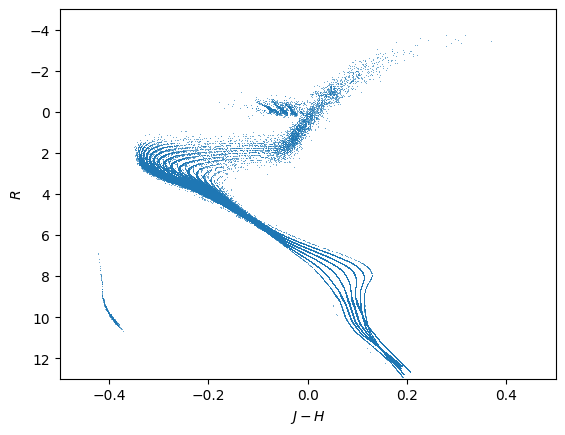

In [38]:
plt.scatter(Jdata-Hdata, Rdata, s=0.5, lw=0,alpha=0.5)

plt.xlim(-0.5, 0.5)
plt.ylim(13,-5)
plt.xlabel(r"$J- H$")
plt.ylabel(r"$R$")